In [1]:
import os
import json
import random
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
import networkx.algorithms.centrality as centrality
import networkx.algorithms.shortest_paths.generic as nxpath 

In [2]:
def get_value(name, maps):
    for nodes in maps:
        if nodes["name"] == name:
            return nodes["value"]
        
def sort(hashmap):
    return sorted(hashmap.items(), key = lambda x: x[1])[::-1]

def get_info(data):
    connections = defaultdict(int)
    interactions = defaultdict(int)
    for link in data["links"]:
        connections[data["nodes"][link["source"]]["name"]] += 1
        connections[data["nodes"][link["target"]]["name"]] += 1
        interactions[data["nodes"][link["source"]]["name"]] += link["value"]
        interactions[data["nodes"][link["target"]]["name"]] += link["value"]
    return connections, interactions
   
def get_graph(data, episode):
    nodes = [ node['name'] for node in data["nodes"] ]
    edges = [ (nodes[link['source']], nodes[link['target']]) for link in data["links"] ]
    G = nx.Graph()
    for node in nodes:
        G.add_node(node)
    for edge in edges:
        G.add_edge(edge[0],edge[1])
        
#     Uncomment block for graph visualization

    plt.figure(figsize=(30,15))
    plt.subplot(121)
    nx.draw(G, with_labels=True)
    plt.savefig(f'task4_results/graphs/Episode_{episode}_Graph.png')
    plt.show()
    plt.close()

    return G

In [3]:
def get_homophily(data, characters):
    sides = []
    for side in characters.values():
        arr = []
        for count in range(len(data["nodes"])):
            if data["nodes"][count]["name"] in side:
                arr.append(count)
        sides.append(arr)
    
    homophily = []
    for side in sides:
        interacts = defaultdict(int)
        for link in data["links"]:
            if link["source"] in side:
                interacts[data["nodes"][link["target"]]["name"]] += link["value"]
                interacts[data["nodes"][link["source"]]["name"]] += link["value"]
            elif link["target"] in side:
                interacts[data["nodes"][link["source"]]["name"]] += link["value"]
                interacts[data["nodes"][link["target"]]["name"]] += link["value"]
        homophily.append(sorted(interacts.items(), key = lambda x: x[1])[::-1][:10])
    return homophily
                
def light_dark_classification(data, sides):
    light_side = []
    dark_side = []
    for i,j in sides.items():
        if j == '1':
            light_side.append(i)
        else:
            dark_side.append(i)

    sides = []
    for side in [light_side, dark_side]:
        arr = []
        for count in range(len(data["nodes"])):
            if data["nodes"][count]["name"] in side:
                arr.append(count)
        sides.append(arr)

    good = defaultdict(int)
    bad = defaultdict(int)
    for character in sides[0]:
        for link in data["links"]:
            if (link["source"] == character and link["target"] in sides[0]) or (link["target"] == character and link["source"] in sides[0]):
                good[data["nodes"][character]["name"]] += link["value"]/len(sides[0])  
            elif (link["source"] == character and link["target"] in sides[1]) or (link["target"] == character and link["source"] in sides[1]):
                bad[data["nodes"][character]["name"]] += link["value"]/len(sides[1])

    for elem in good.keys():
        if elem not in bad.keys():
            bad[elem] = 0

    for elem in bad.keys():
        if elem not in good.keys():
            good[elem] = 0

    correct = 0
    incorrect = 0
    for l, d in zip(sorted(good.items()), sorted(bad.items())):
        if l[1] >= d[1]:
            if l[0] in light_side:
                correct += 1
            else:
                incorrect += 1
        else:
            if d[0] in dark_side:
                correct += 1
            else:
                incorrect += 1

    return (correct, incorrect)

In [4]:
def get_randomness(G, p):
    G.remove_nodes_from(list(nx.isolates(G)))
    spread = []
    spread_paths = []
    for j in range(1, len(list(G))):
        spread.append(G)
        spread_paths.append(nx.average_shortest_path_length(G))
        if random.randint(0, 100) < p*100:
            edges = list(set(G.edges) - set(nx.bridges(G)))
            if edges:
                u, v = random.choice(edges)
                G.remove_edge(u, v)
                w = random.choice(list(set(G) - set(x for _,x in set(G.edges(u))))) 
                G.add_edge(u, w)
    return spread, spread_paths

In [5]:
def loop(episode, feature):
    with open(f'data/starwars-episode-{episode}-{feature}.json') as f:
        data = json.load(f)
        
    with open('character_side.json') as d:
        sides = json.load(d)    
    
    characters = {
        "Light Side": ["FINN", "OBI-WAN", "YODA", "PADME", "LUKE"], 
        "Dark Side": ["EMPEROR","DARTH VADER", "PIETT", "GENERAL HUX", "NUTE GUNRAY"]
    }    
    
    probability = 0.7
    
#     Task 2 Hypothesis 1
    connections, interractions = get_info(data)
    homophily = get_homophily(data, characters)
    classification = light_dark_classification(data, sides)
    
    Graph  = get_graph(data, episode)
    
    #     Task 2 Hypothesis 2
    betweenness = sort(centrality.betweenness_centrality(Graph))[:5]
    degree_centrality = sort(connections)[:5]
    
    #     Task 3
    cliquishness = sort(nx.clustering(Graph))[:5]
    path_length = list(nxpath.shortest_path_length(Graph))
    randomness = get_randomness(Graph, probability)
    
#     Uncomment to display randomness graphs and save them
    for graph in range(1, len(randomness[0]), 10):
        plt.figure(figsize=(30,15))
        plt.subplot(121)
        nx.draw(randomness[0][graph], with_labels=True)
        plt.savefig(f'task3_results/Episode{episode}_{graph}.png')
        plt.close()
        
#     Task 4, 5
    temp = set()
    for i,j in zip(connections.items(), interractions.items()):
        temp.add((i[0], i[1], j[1], get_value(i[0], data["nodes"])))
    temp = sorted(temp, key = lambda x: x[1])[::-1]
    
#     Uncomment block for visualizations

    plt.figure(figsize=(25,10))
    plt.title(f'Episode-{episode} {feature}')
    plt.plot(list(zip(*temp))[0], list(zip(*temp))[1], list(zip(*temp))[0], list(zip(*temp))[2], list(zip(*temp))[0], list(zip(*temp))[3])
    plt.xticks(list(zip(*temp))[0][::1],  rotation='vertical')
    plt.savefig(f'task4_results/images/Episode_{episode}_{feature}.png')
    plt.show()
    plt.close()
    
    return (homophily, classification), (betweenness, degree_centrality), (cliquishness, path_length, randomness[1]), (connections, interractions)

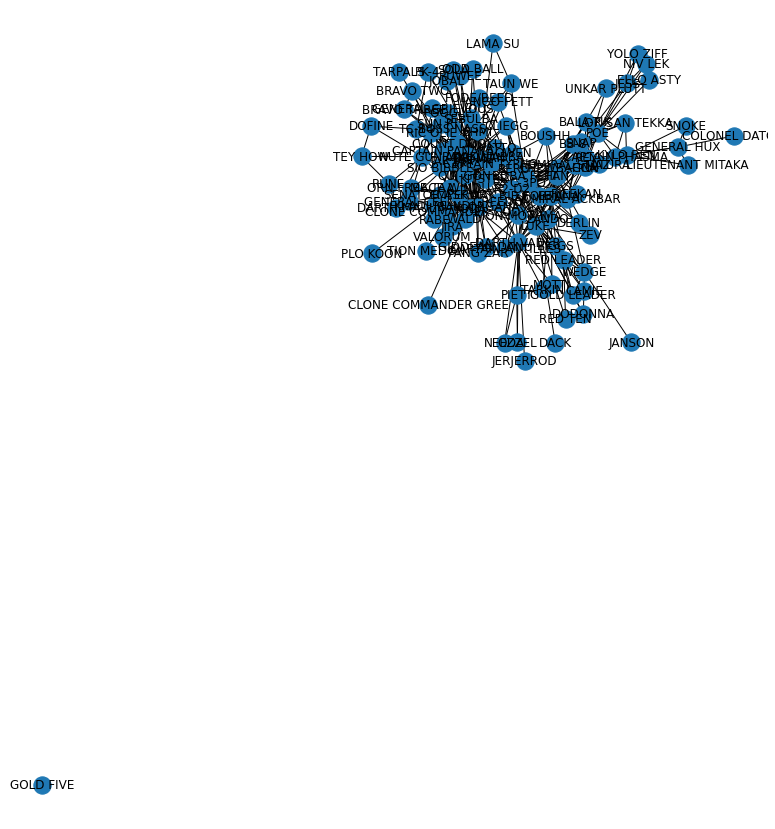

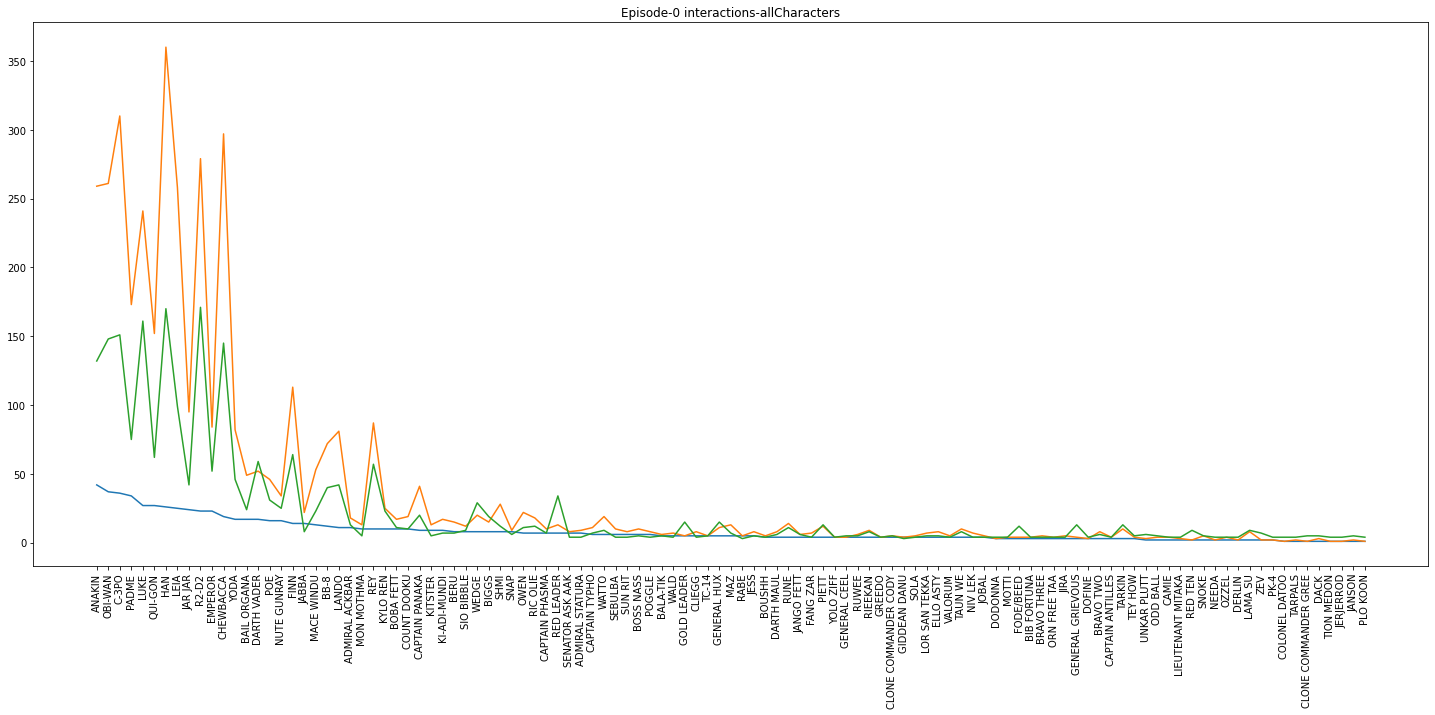


 Episode 0 

 Task 1 and 2

 Hypothesis 1 Analysis 

 Homophily 
 [[('OBI-WAN', 261), ('LUKE', 241), ('PADME', 173), ('FINN', 113), ('ANAKIN', 97), ('R2-D2', 91), ('YODA', 82), ('HAN', 76), ('CHEWBACCA', 58), ('C-3PO', 52)], [('EMPEROR', 84), ('DARTH VADER', 52), ('NUTE GUNRAY', 34), ('ANAKIN', 16), ('PIETT', 12), ('GENERAL HUX', 11), ('RUNE', 11), ('LUKE', 10), ('TARKIN', 7), ('OBI-WAN', 7)]] 

 Classification (correct side, wrong side) (73, 7)

 Hypothesis 2 Analysis 

 Betweenness 
 [('OBI-WAN', 0.20527616510286287), ('C-3PO', 0.16810394625192118), ('ANAKIN', 0.158361912998823), ('LUKE', 0.14168316245036236), ('HAN', 0.09639612279428685)] 

 Degree_centrality 
 [('ANAKIN', 42), ('OBI-WAN', 37), ('C-3PO', 36), ('PADME', 34), ('LUKE', 27)]

 Task 3 

 Cliquishness 
 [('NIV LEK', 1.0), ('ELLO ASTY', 1.0), ('YOLO ZIFF', 1.0), ('ADMIRAL STATURA', 1.0), ('MAZ', 1.0)] 

 Path_length 
 [('R2-D2', {'R2-D2': 0, 'CHEWBACCA': 1, 'BB-8': 1, 'OBI-WAN': 1, 'PADME': 1, 'QUI-GON': 1, 'ANAKIN': 1, '

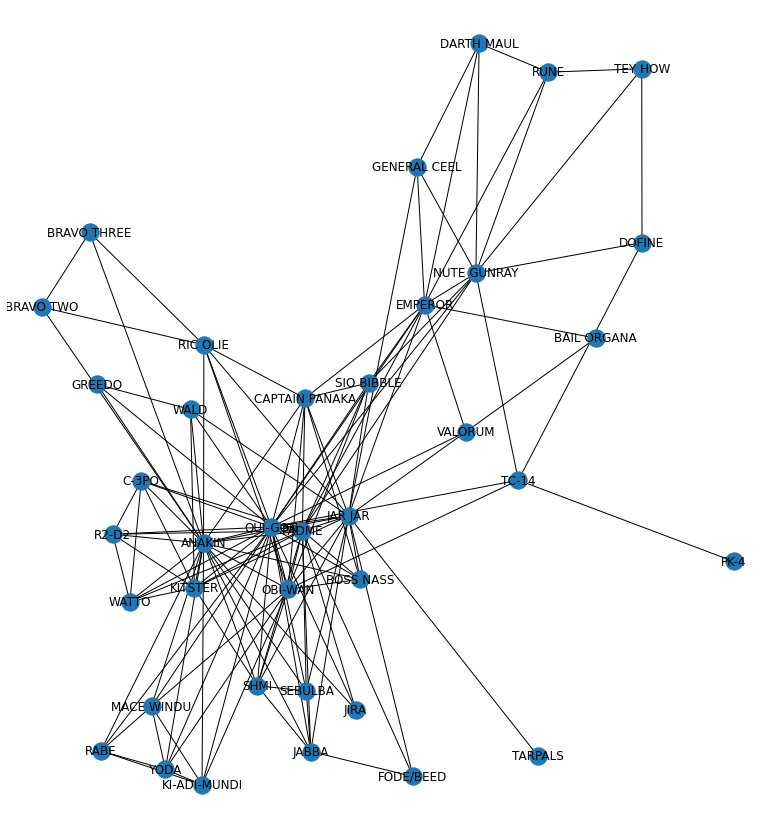

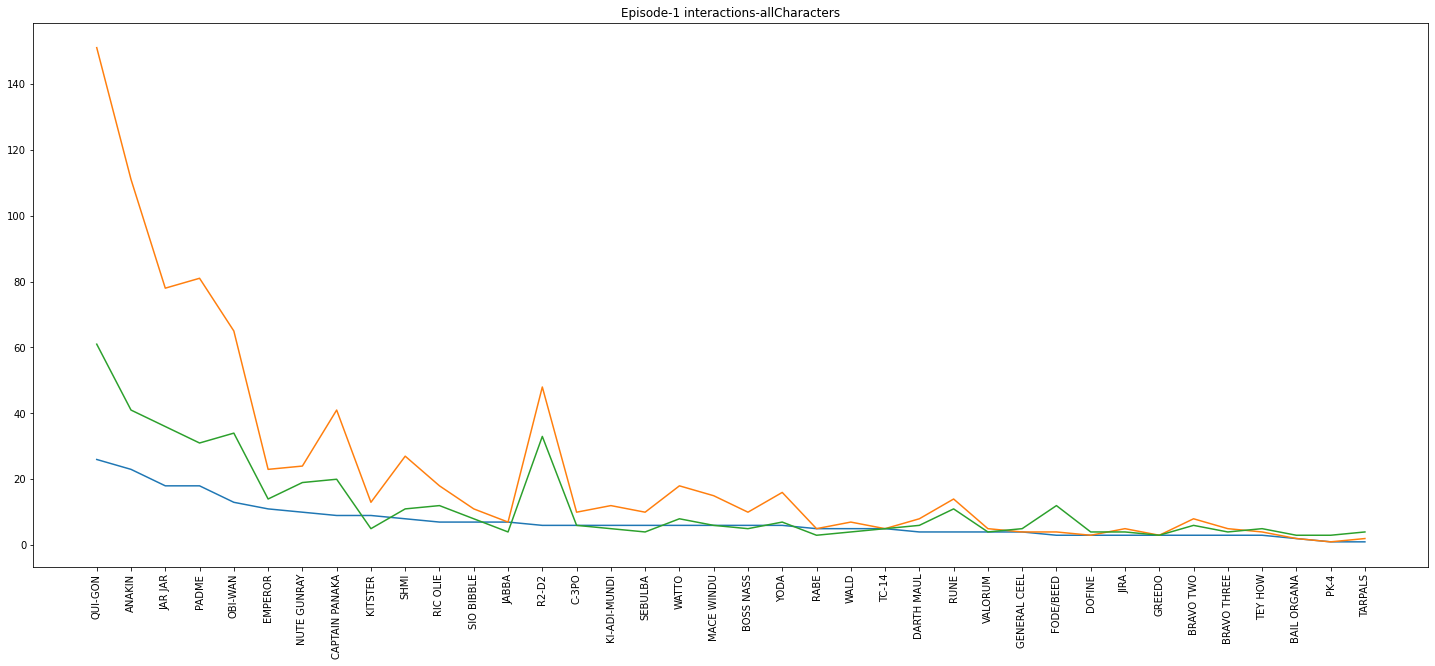


 Episode 1 

 Task 1 and 2

 Hypothesis 1 Analysis 

 Homophily 
 [[('PADME', 81), ('OBI-WAN', 65), ('QUI-GON', 44), ('ANAKIN', 24), ('JAR JAR', 21), ('YODA', 16), ('CAPTAIN PANAKA', 14), ('R2-D2', 11), ('MACE WINDU', 6), ('SHMI', 6)], [('NUTE GUNRAY', 24), ('EMPEROR', 23), ('RUNE', 11), ('DARTH MAUL', 6), ('SIO BIBBLE', 3), ('CAPTAIN PANAKA', 3), ('PADME', 2), ('GENERAL CEEL', 2), ('JAR JAR', 2), ('VALORUM', 2)]] 

 Classification (correct side, wrong side) (23, 3)

 Hypothesis 2 Analysis 

 Betweenness 
 [('QUI-GON', 0.3226135226135226), ('ANAKIN', 0.16988362821696157), ('JAR JAR', 0.14583615000281666), ('NUTE GUNRAY', 0.1254313837647171), ('PADME', 0.10342138675472008)] 

 Degree_centrality 
 [('QUI-GON', 26), ('ANAKIN', 23), ('JAR JAR', 18), ('PADME', 18), ('OBI-WAN', 13)]

 Task 3 

 Cliquishness 
 [('BRAVO THREE', 1.0), ('BRAVO TWO', 1.0), ('BAIL ORGANA', 1.0), ('RABE', 1.0), ('GREEDO', 1.0)] 

 Path_length 
 [('R2-D2', {'R2-D2': 0, 'PADME': 1, 'QUI-GON': 1, 'ANAKIN': 1, 'WATTO'

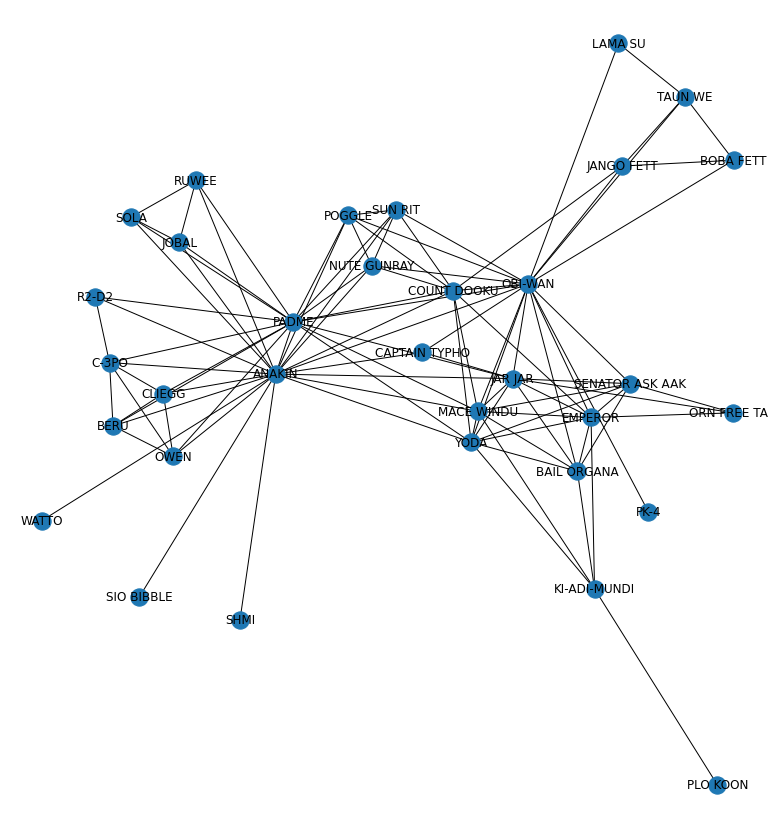

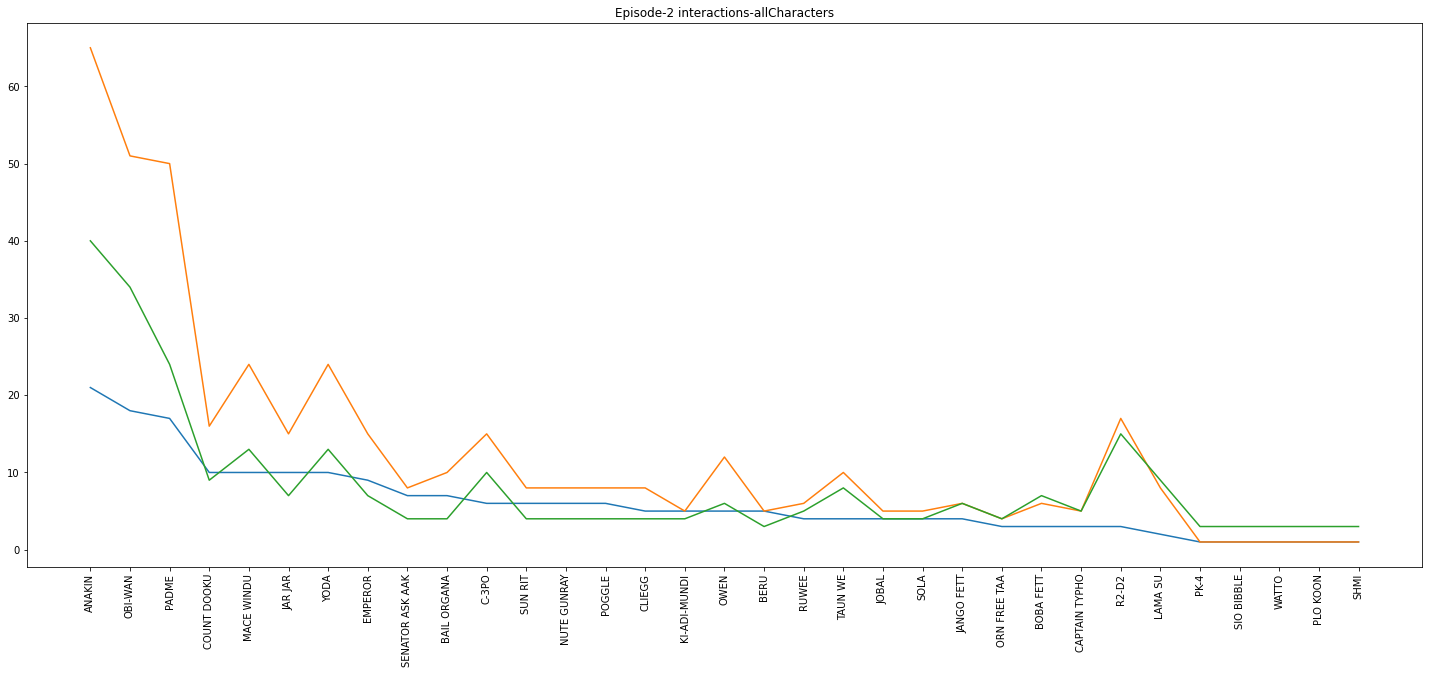


 Episode 2 

 Task 1 and 2

 Hypothesis 1 Analysis 

 Homophily 
 [[('OBI-WAN', 51), ('PADME', 50), ('ANAKIN', 30), ('YODA', 24), ('MACE WINDU', 14), ('COUNT DOOKU', 7), ('R2-D2', 7), ('LAMA SU', 6), ('C-3PO', 5), ('TAUN WE', 5)], [('EMPEROR', 15), ('NUTE GUNRAY', 8), ('COUNT DOOKU', 2), ('POGGLE', 2), ('SUN RIT', 2), ('JAR JAR', 2), ('OBI-WAN', 2), ('BAIL ORGANA', 2), ('YODA', 2), ('MACE WINDU', 2)]] 

 Classification (correct side, wrong side) (23, 0)

 Hypothesis 2 Analysis 

 Betweenness 
 [('ANAKIN', 0.3833822091886608), ('OBI-WAN', 0.31480109272447976), ('PADME', 0.1789467253176931), ('KI-ADI-MUNDI', 0.0625), ('JAR JAR', 0.06213037634408606)] 

 Degree_centrality 
 [('ANAKIN', 21), ('OBI-WAN', 18), ('PADME', 17), ('COUNT DOOKU', 10), ('JAR JAR', 10)]

 Task 3 

 Cliquishness 
 [('NUTE GUNRAY', 1.0), ('POGGLE', 1.0), ('SUN RIT', 1.0), ('CLIEGG', 1.0), ('BERU', 1.0)] 

 Path_length 
 [('R2-D2', {'R2-D2': 0, 'PADME': 1, 'ANAKIN': 1, 'C-3PO': 1, 'JAR JAR': 2, 'SOLA': 2, 'JOBAL': 2, 

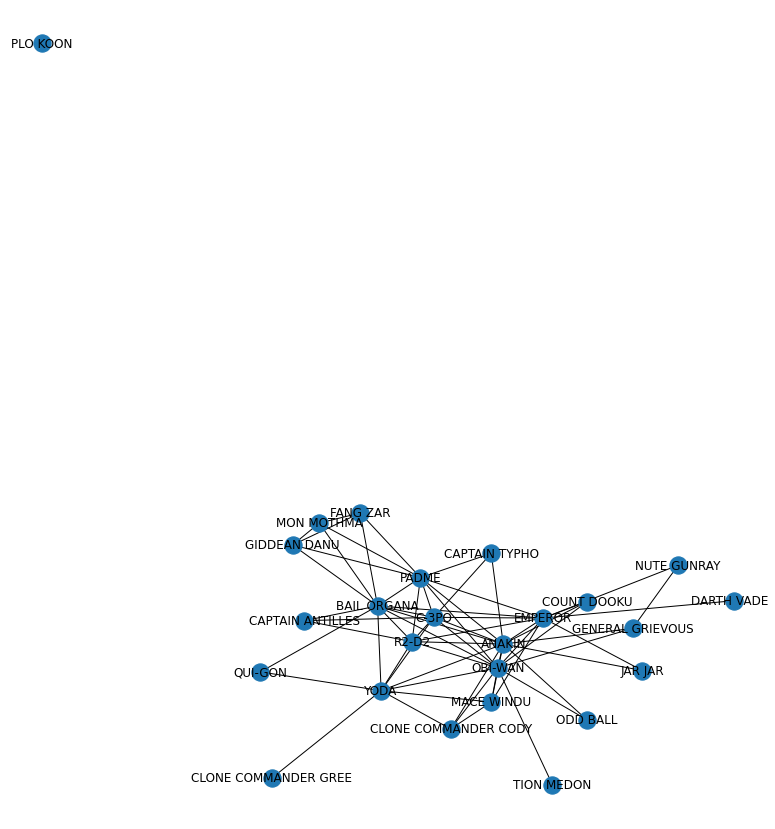

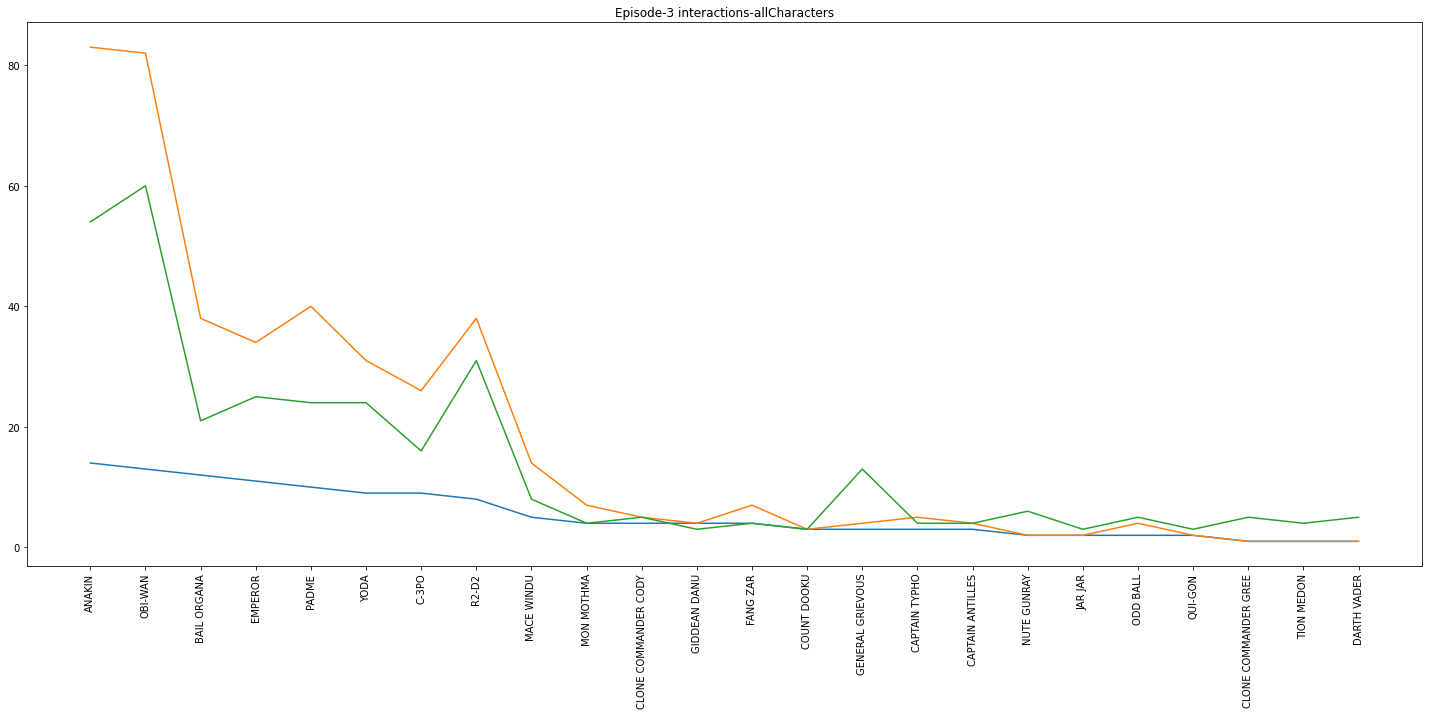


 Episode 3 

 Task 1 and 2

 Hypothesis 1 Analysis 

 Homophily 
 [[('OBI-WAN', 82), ('ANAKIN', 42), ('PADME', 40), ('YODA', 31), ('BAIL ORGANA', 18), ('R2-D2', 17), ('C-3PO', 9), ('EMPEROR', 8), ('MACE WINDU', 7), ('CLONE COMMANDER CODY', 3)], [('EMPEROR', 34), ('ANAKIN', 14), ('PADME', 4), ('OBI-WAN', 4), ('BAIL ORGANA', 3), ('NUTE GUNRAY', 2), ('C-3PO', 2), ('R2-D2', 2), ('DARTH VADER', 1), ('MACE WINDU', 1)]] 

 Classification (correct side, wrong side) (18, 1)

 Hypothesis 2 Analysis 

 Betweenness 
 [('OBI-WAN', 0.18631815044858524), ('ANAKIN', 0.1847481021394065), ('EMPEROR', 0.18323844030365768), ('BAIL ORGANA', 0.1818754313319531), ('YODA', 0.11592477570738441)] 

 Degree_centrality 
 [('ANAKIN', 14), ('OBI-WAN', 13), ('BAIL ORGANA', 12), ('EMPEROR', 11), ('PADME', 10)]

 Task 3 

 Cliquishness 
 [('QUI-GON', 1.0), ('CAPTAIN ANTILLES', 1.0), ('JAR JAR', 1.0), ('CLONE COMMANDER CODY', 1.0), ('CAPTAIN TYPHO', 1.0)] 

 Path_length 
 [('R2-D2', {'R2-D2': 0, 'EMPEROR': 1, 'OBI-WAN

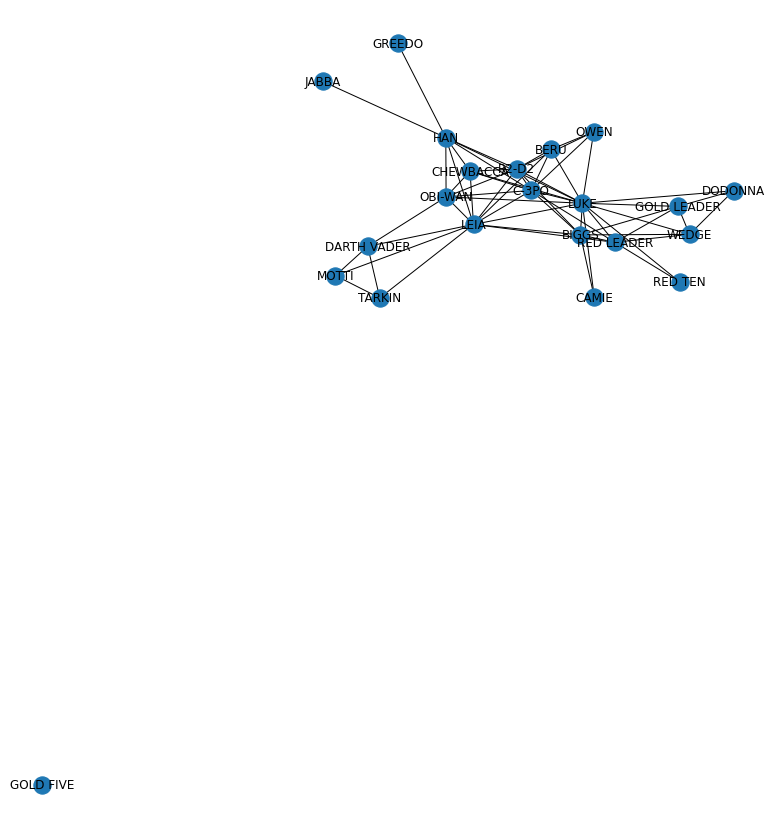

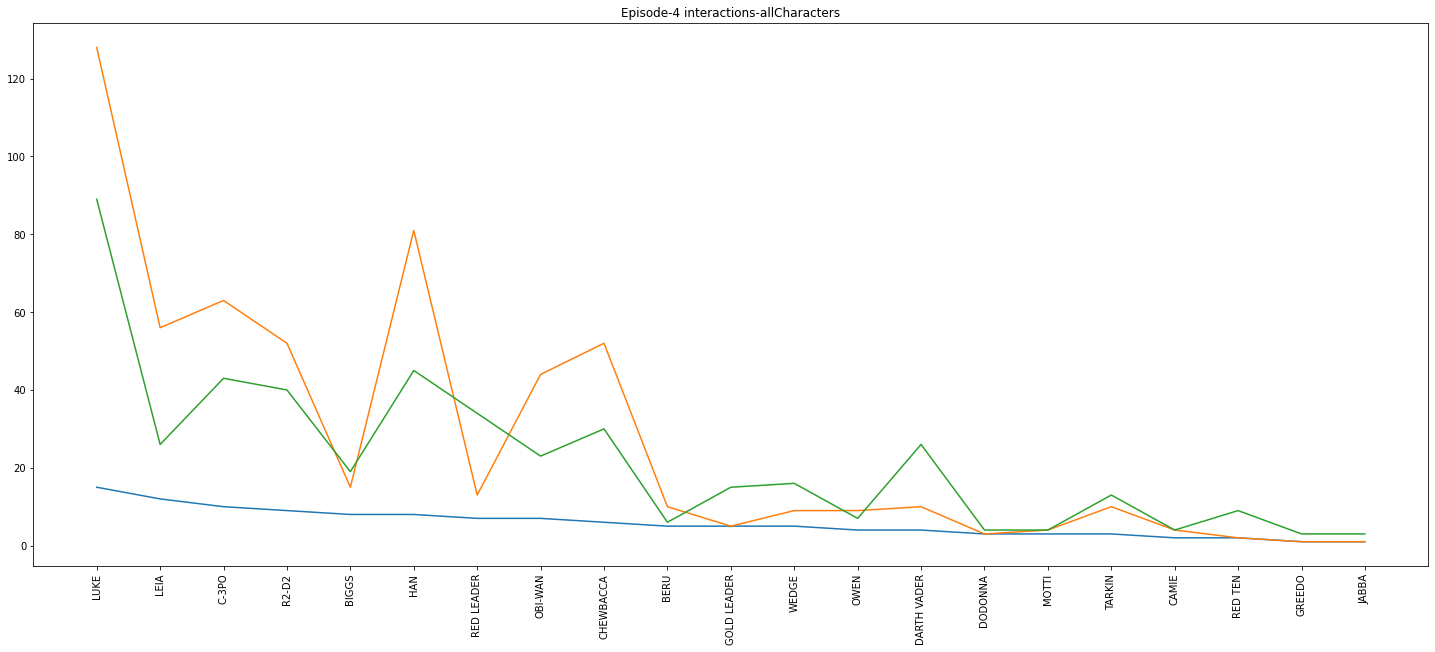


 Episode 4 

 Task 1 and 2

 Hypothesis 1 Analysis 

 Homophily 
 [[('LUKE', 128), ('OBI-WAN', 44), ('HAN', 35), ('C-3PO', 24), ('LEIA', 18), ('CHEWBACCA', 18), ('R2-D2', 18), ('BIGGS', 4), ('RED LEADER', 3), ('OWEN', 3)], [('DARTH VADER', 10), ('TARKIN', 7), ('OBI-WAN', 1), ('MOTTI', 1), ('LEIA', 1)]] 

 Classification (correct side, wrong side) (17, 0)

 Hypothesis 2 Analysis 

 Betweenness 
 [('LUKE', 0.3223922902494331), ('LEIA', 0.2304988662131519), ('HAN', 0.1761904761904762), ('BIGGS', 0.041666666666666664), ('C-3PO', 0.04064625850340136)] 

 Degree_centrality 
 [('LUKE', 15), ('LEIA', 12), ('C-3PO', 10), ('R2-D2', 9), ('HAN', 8)]

 Task 3 

 Cliquishness 
 [('RED TEN', 1.0), ('DODONNA', 1.0), ('TARKIN', 1.0), ('MOTTI', 1.0), ('OWEN', 1.0)] 

 Path_length 
 [('R2-D2', {'R2-D2': 0, 'CHEWBACCA': 1, 'C-3PO': 1, 'BERU': 1, 'LUKE': 1, 'OWEN': 1, 'OBI-WAN': 1, 'LEIA': 1, 'BIGGS': 1, 'HAN': 1, 'RED LEADER': 2, 'CAMIE': 2, 'DODONNA': 2, 'GOLD LEADER': 2, 'WEDGE': 2, 'RED TEN': 2, 'DART

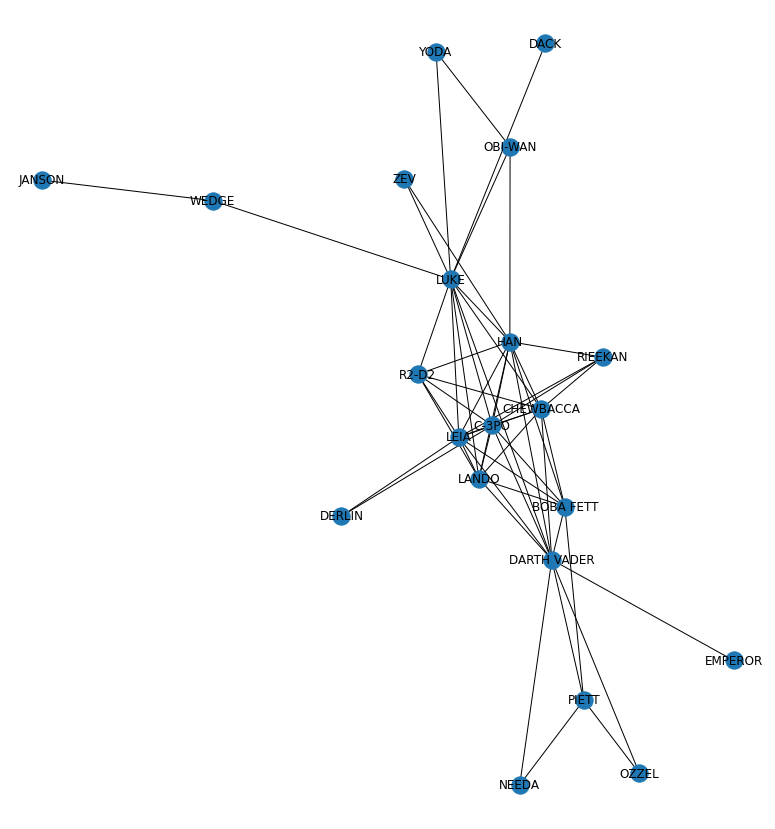

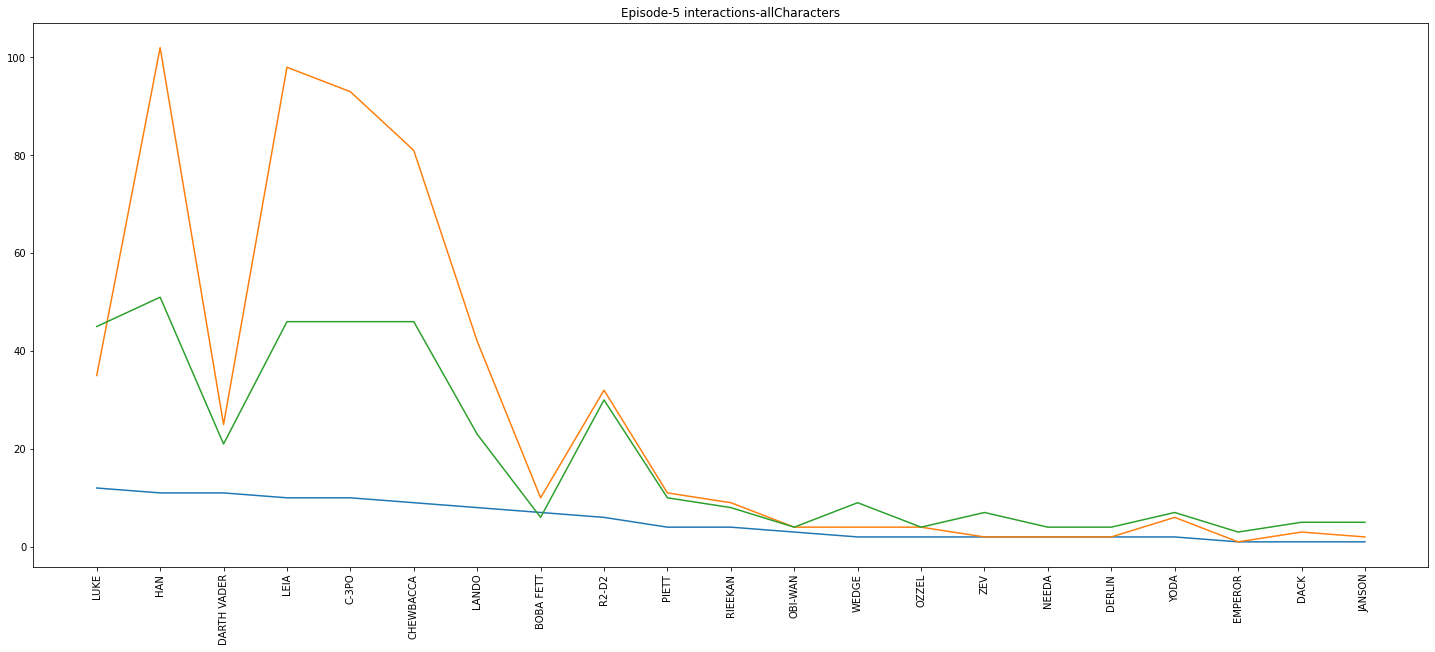


 Episode 5 

 Task 1 and 2

 Hypothesis 1 Analysis 

 Homophily 
 [[('LUKE', 35), ('R2-D2', 7), ('YODA', 6), ('HAN', 5), ('CHEWBACCA', 5), ('OBI-WAN', 4), ('DACK', 3), ('LANDO', 2), ('DARTH VADER', 2), ('WEDGE', 2)], [('DARTH VADER', 25), ('PIETT', 11), ('LANDO', 4), ('BOBA FETT', 4), ('OZZEL', 4), ('LUKE', 2), ('HAN', 2), ('NEEDA', 2), ('LEIA', 1), ('C-3PO', 1)]] 

 Classification (correct side, wrong side) (15, 1)

 Hypothesis 2 Analysis 

 Betweenness 
 [('LUKE', 0.41621781727044893), ('DARTH VADER', 0.3246753246753247), ('HAN', 0.11175894281157435), ('WEDGE', 0.09999999999999999), ('C-3PO', 0.07398951925267716)] 

 Degree_centrality 
 [('LUKE', 12), ('DARTH VADER', 11), ('HAN', 11), ('LEIA', 10), ('C-3PO', 10)]

 Task 3 

 Cliquishness 
 [('YODA', 1.0), ('NEEDA', 1.0), ('OZZEL', 1.0), ('ZEV', 1.0), ('DERLIN', 1.0)] 

 Path_length 
 [('R2-D2', {'R2-D2': 0, 'CHEWBACCA': 1, 'C-3PO': 1, 'LUKE': 1, 'HAN': 1, 'LEIA': 1, 'LANDO': 1, 'RIEEKAN': 2, 'DARTH VADER': 2, 'BOBA FETT': 2, 'DERLIN

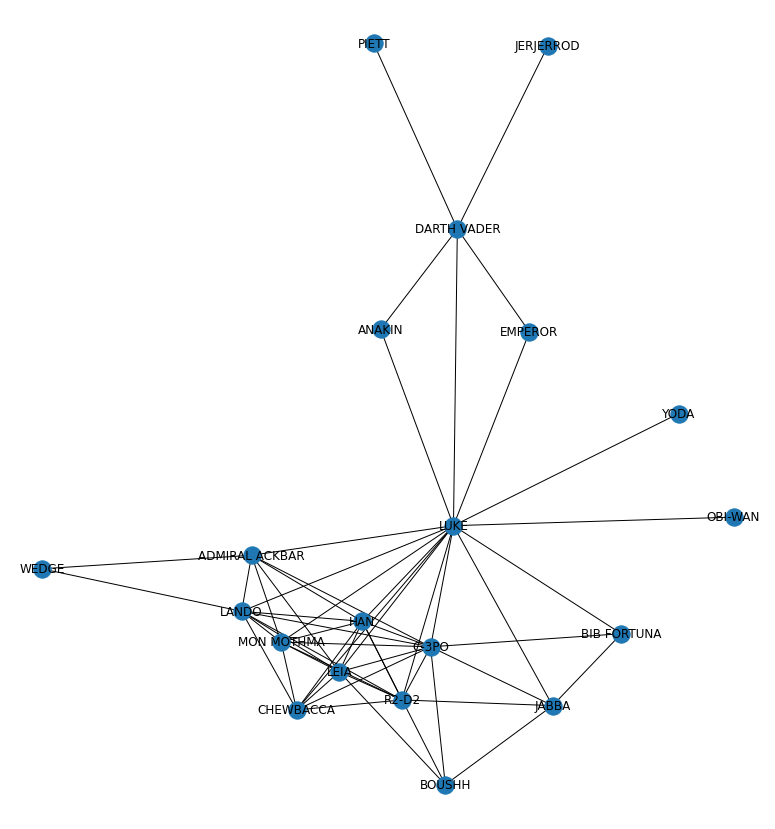

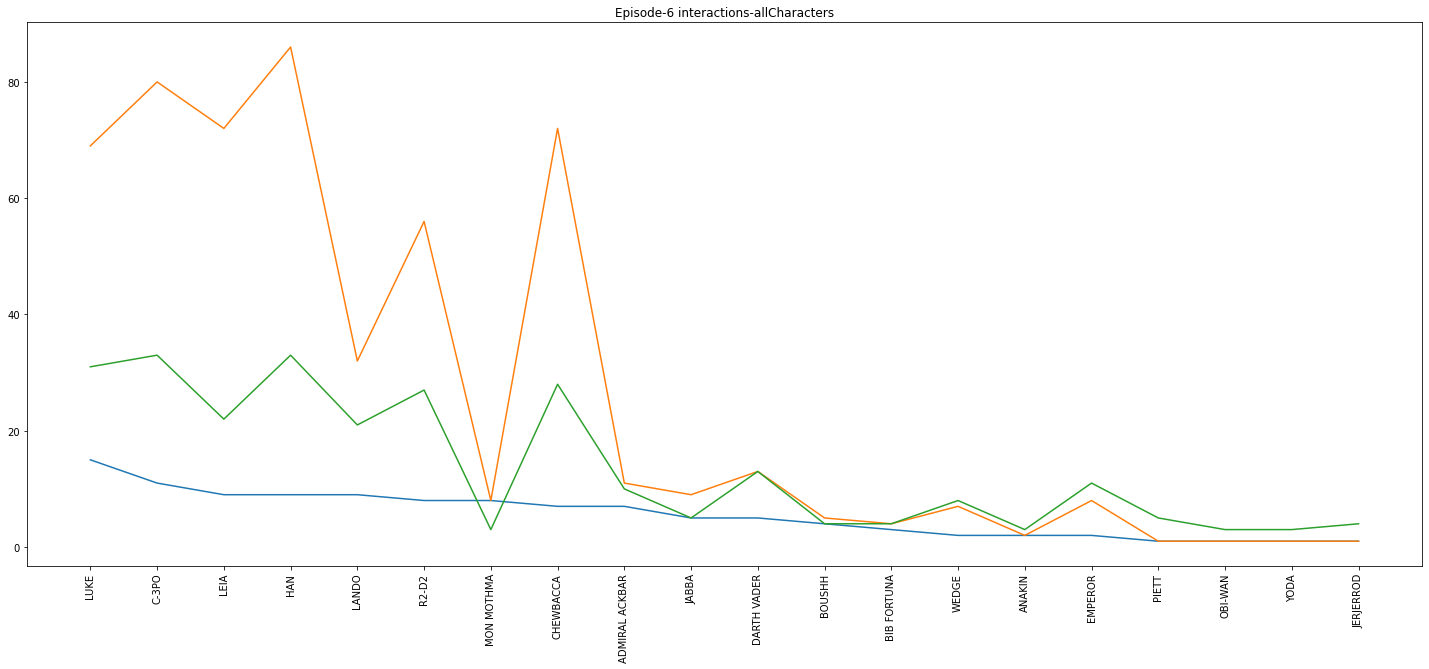


 Episode 6 

 Task 1 and 2

 Hypothesis 1 Analysis 

 Homophily 
 [[('LUKE', 69), ('HAN', 13), ('C-3PO', 10), ('CHEWBACCA', 10), ('LEIA', 8), ('R2-D2', 8), ('DARTH VADER', 5), ('LANDO', 4), ('EMPEROR', 3), ('JABBA', 2)], [('DARTH VADER', 13), ('LUKE', 8), ('EMPEROR', 8), ('ANAKIN', 1), ('PIETT', 1), ('JERJERROD', 1)]] 

 Classification (correct side, wrong side) (14, 1)

 Hypothesis 2 Analysis 

 Betweenness 
 [('LUKE', 0.5968810916179338), ('DARTH VADER', 0.20760233918128654), ('C-3PO', 0.06423001949317739), ('LANDO', 0.058089668615984406), ('ADMIRAL ACKBAR', 0.04327485380116959)] 

 Degree_centrality 
 [('LUKE', 15), ('C-3PO', 11), ('LEIA', 9), ('HAN', 9), ('LANDO', 9)]

 Task 3 

 Cliquishness 
 [('ANAKIN', 1.0), ('WEDGE', 1.0), ('EMPEROR', 1.0), ('BIB FORTUNA', 1.0), ('CHEWBACCA', 1.0)] 

 Path_length 
 [('R2-D2', {'R2-D2': 0, 'CHEWBACCA': 1, 'C-3PO': 1, 'LANDO': 1, 'JABBA': 1, 'LUKE': 1, 'HAN': 1, 'LEIA': 1, 'MON MOTHMA': 1, 'BIB FORTUNA': 2, 'BOUSHH': 2, 'ADMIRAL ACKBAR': 2, 'WE

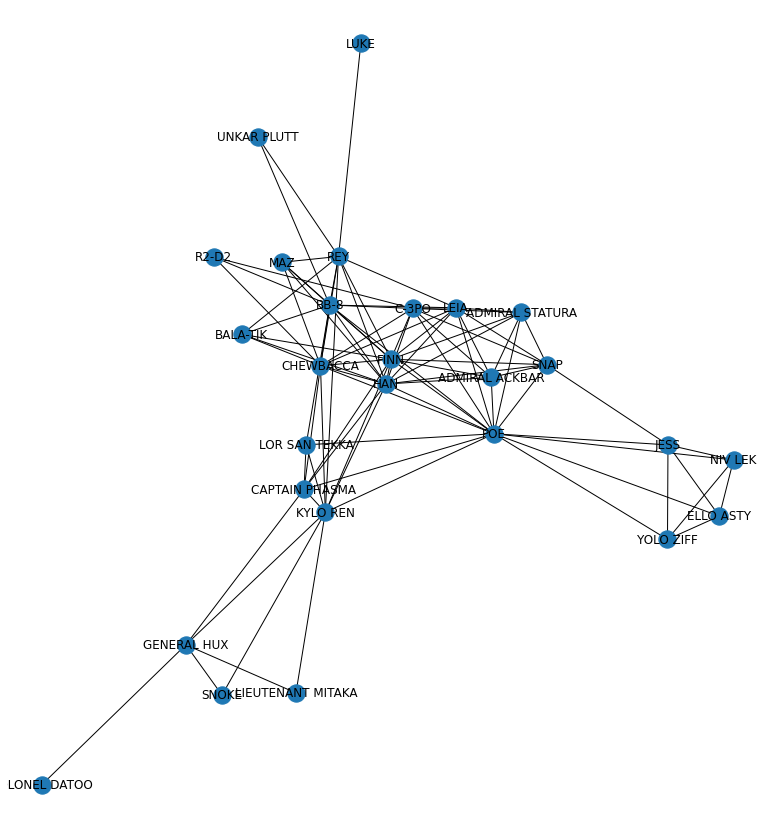

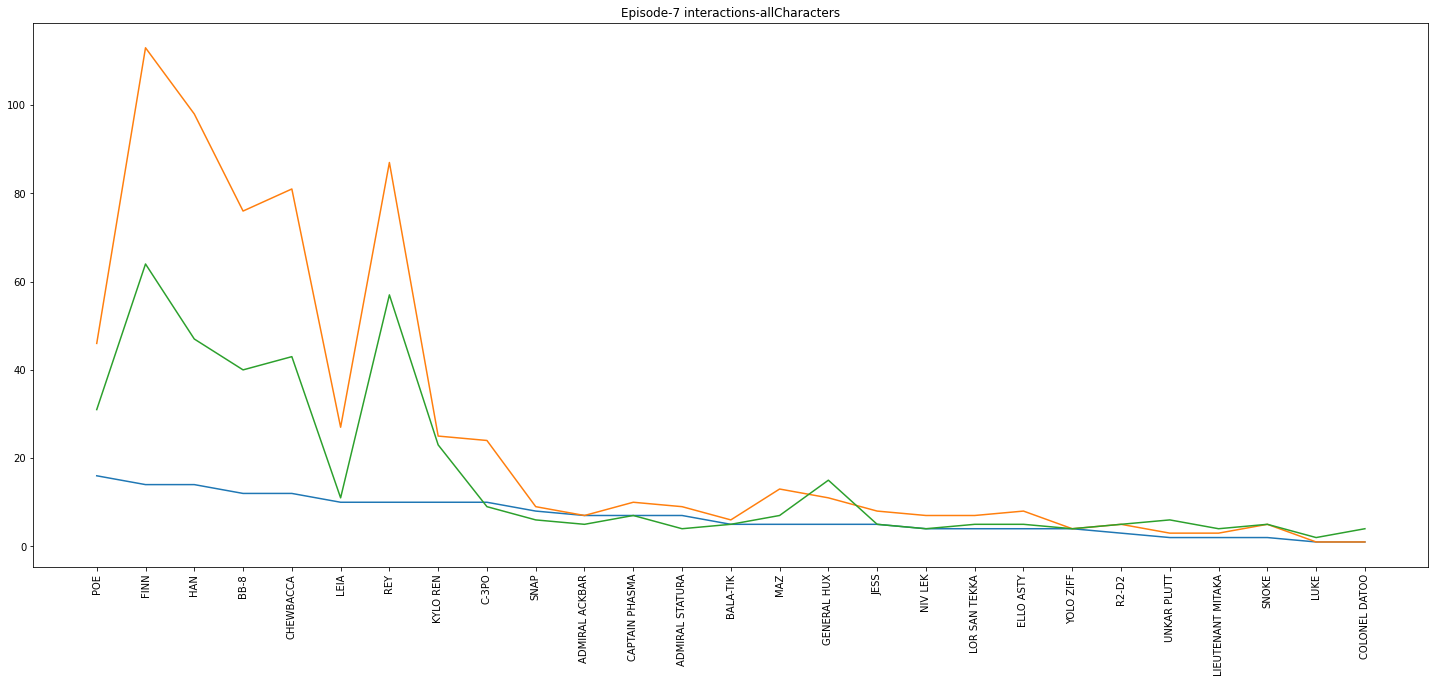


 Episode 7 

 Task 1 and 2

 Hypothesis 1 Analysis 

 Homophily 
 [[('FINN', 113), ('REY', 30), ('HAN', 23), ('CHEWBACCA', 20), ('BB-8', 15), ('POE', 11), ('LEIA', 3), ('CAPTAIN PHASMA', 3), ('KYLO REN', 2), ('MAZ', 2)], [('GENERAL HUX', 11), ('KYLO REN', 5), ('SNOKE', 3), ('COLONEL DATOO', 1), ('CAPTAIN PHASMA', 1), ('LIEUTENANT MITAKA', 1)]] 

 Classification (correct side, wrong side) (20, 3)

 Hypothesis 2 Analysis 

 Betweenness 
 [('POE', 0.2991103341103341), ('KYLO REN', 0.2212443112443113), ('REY', 0.11921511821511821), ('BB-8', 0.08970085470085468), ('HAN', 0.08241314241314242)] 

 Degree_centrality 
 [('POE', 16), ('HAN', 14), ('FINN', 14), ('BB-8', 12), ('CHEWBACCA', 12)]

 Task 3 

 Cliquishness 
 [('NIV LEK', 1.0), ('ELLO ASTY', 1.0), ('YOLO ZIFF', 1.0), ('ADMIRAL STATURA', 1.0), ('ADMIRAL ACKBAR', 1.0)] 

 Path_length 
 [('LUKE', {'LUKE': 0, 'REY': 1, 'CHEWBACCA': 2, 'BB-8': 2, 'UNKAR PLUTT': 2, 'FINN': 2, 'HAN': 2, 'BALA-TIK': 2, 'MAZ': 2, 'KYLO REN': 2, 'LEIA': 2, 'R2-

In [6]:
if __name__ == "__main__":

    if not os.path.exists('task3_results'):
        os.makedirs('task3_results')
    if not os.path.exists('task4_results'):
        os.makedirs('task4_results')
        os.makedirs('task4_results/images')
        os.makedirs('task4_results/graphs')
        
#     Define feature depending on what characteristics you wish to amalyze with
    feature = "interactions-allCharacters"
#     features = "mentions"

    # considering episode 0 as full series
    for episode in range(0,8):
        hypothesis_1, hypothesis_2, task_3, task_4_and_5 = loop(episode, feature)
        print(f"\n Episode {episode} \n\n Task 1 and 2")
        print(f"\n Hypothesis 1 Analysis \n\n Homophily \n {hypothesis_1[0]} \n\n Classification (correct side, wrong side) {hypothesis_1[1]}")
        print(f"\n Hypothesis 2 Analysis \n\n Betweenness \n {hypothesis_2[0]} \n\n Degree_centrality \n {hypothesis_2[1]}")        
        print(f"\n Task 3 \n\n Cliquishness \n {task_3[0]} \n\n Path_length \n {task_3[1]} \n \n Average Path Length when adding randomness\n {task_3[2]}")
        print(f"\n Task 4 and 5 \n\n Connections \n {task_4_and_5[0]} \n\n Interactions \n {task_4_and_5[1]}")